In [221]:
%matplotlib inline  
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from glob import glob
import pickle

In [222]:
window_length = 256

overlap = round(0.25 * window_length) # overlap of 75%

n_fft = window_length

feature_sample = 8000

n_features = n_fft//2 + 1

n_segments = 8

n_clean_segments = 1

demonstration_path = 'X_train_demonstration.pkl'
X_training = 'X_train_2.pkl'
Y_training = 'Y_train_2.pkl'

random_noise_index_max = 2000

In [223]:

# Read audiofiles
def read_audio_file(filepath, sample_rate, normalize = True):
    audio, _ = librosa.load(filepath, sr=sample_rate)
    audio, _ = librosa.effects.trim(audio)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio

speech_files = glob('data/input/speech/*.mp3')
noise_files = glob('data/input/noise/*/*.wav')

np.random.shuffle(noise_files)
np.random.shuffle(speech_files)

X_files = [read_audio_file(files, feature_sample) for files in speech_files[:500]]
noise_files = [read_audio_file(files, feature_sample) for files in noise_files[:random_noise_index_max]]
Y_files = X_files

# to show audiofile
# random_index = np.random.randint(0, 1)

In [224]:
# Add noise to audio 
def mix_audio(signal, noise, snr):
    # if the audio is longer than the noise
    # play the noise in repeat for the duration of the audio
    noise = noise[np.arange(len(signal)) % len(noise)]
    
    # if the audio is shorter than the noise
    noise = noise.astype(np.float32)
    signal = signal.astype(np.float32)
    
    # get the initial energy for reference
    signal_energy = np.mean(signal**2)
    noise_energy = np.mean(noise**2)
    # calculates the gain to be applied to the noise 
    # to achieve the given SNR
    g = np.sqrt(10.0 ** (-snr/10) * signal_energy / noise_energy)
    
    # Assumes signal and noise to be decorrelated
    # and calculate (a, b) such that energy of 
    # a*signal + b*noise matches the energy of the input signal
    a = np.sqrt(1 / (1 + g**2))
    b = np.sqrt(g**2 / (1 + g**2))
    # mix the signals
    return a * signal + b * noise

def make_some_noise(X_files, noise_files):
    result_list = []
    for files in X_files:
        noise_file_index = np.random.randint(0, random_noise_index_max)
        result_list.append(mix_audio(files, noise_files[noise_file_index], 0))
        
    return result_list

X_files = make_some_noise(X_files, noise_files)

# sf.write('noisy_file_example.wav', X_files[random_index], feature_sample)
# sf.write('clean_file_example.wav', Y_files[random_index], feature_sample)

In [225]:
# Get stft spectrogram
def read_as_stft_spectrogram(audio):
    return librosa.stft(y=audio, n_fft=n_fft,hop_length=overlap, center=True, window='hamming')

def convert_audio_to_image(audio_files):
    return [read_as_stft_spectrogram(items) for items in audio_files]

X = convert_audio_to_image(X_files)
Y = convert_audio_to_image(Y_files)

/tmp/ipykernel_395/3180684966.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  result = librosa.amplitude_to_db(spectrogram, ref=np.max).astype(np.float32)


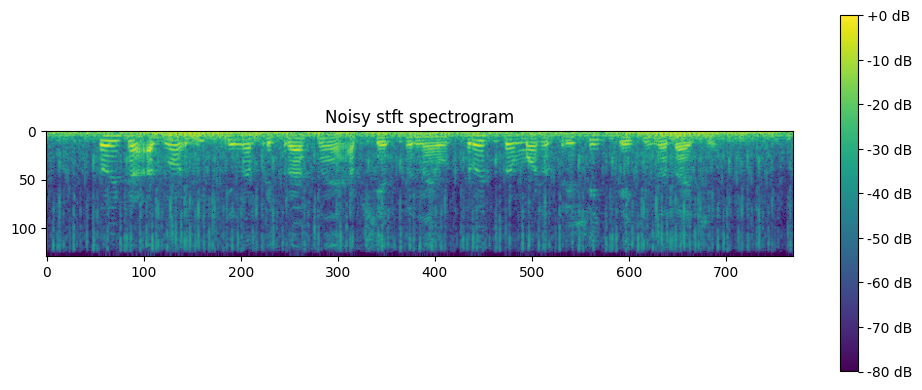

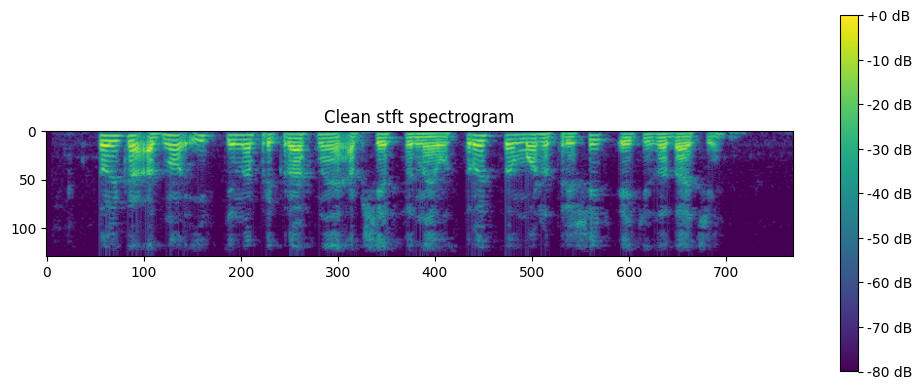

In [226]:
def show_spectrogram(spectrogram, title):
    result = librosa.amplitude_to_db(spectrogram, ref=np.max).astype(np.float32)
    plt.figure(figsize=(10,4))
    plt.imshow(result)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

# show_spectrogram(X[random_index], "Noisy stft spectrogram")
# show_spectrogram(Y[random_index], "Clean stft spectrogram")

In [227]:
# Steps according to paper
# phase = np.angle(X[0])
# pickle.dump(phase, open('phase.pkl', 'wb'))

def means(audio):
    stft_feature = np.abs(audio)
    mean = np.mean(stft_feature)
    std = np.std(stft_feature)
    # print(mean, std)
    return (stft_feature - mean) / std

X = [means(audio) for audio in X]
Y = [means(audio) for audio in Y]

0.17156526 0.4684147
0.10795545 0.42166725


In [228]:
def prepare_input_features(stft_features, n_segments):
    stft_feature = np.concatenate([stft_features[:,0:n_segments-1], stft_features], axis=1)
    stft_segments = np.zeros((n_features, n_segments , stft_feature.shape[1] - n_segments + 1))

    for index in range(stft_feature.shape[1] - n_segments + 1):
        stft_segments[:,:,index] = stft_feature[:,index:index + n_segments]
    return stft_segments

X_predictors = [prepare_input_features(stft_feature, n_segments) for stft_feature in X]
Y_predictors = [prepare_input_features(stft_feature, n_clean_segments) for stft_feature in Y]

print(X_predictors[0].shape, Y_predictors[0].shape)

(129, 8, 770) (129, 1, 770)


In [229]:
def reshape_predictors(predictors):
    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    # print('predictors.shape:', predictors.shape)
    return predictors
    
X_predictors = np.asarray([reshape_predictors(predictors) for predictors in X_predictors], dtype=object)
Y_predictors = np.asarray([reshape_predictors(predictors) for predictors in Y_predictors], dtype=object)

In [230]:
# prepare and write dataset 

x_data = X_predictors[0]
y_data = Y_predictors[0]

for index in range(1, len(X_predictors)):
    x_data = np.concatenate((x_data, X_predictors[index]))
    y_data = np.concatenate((y_data, Y_predictors[index]))

# print(x_data.shape)

pickle.dump(x_data, open(X_training, 'wb'))
pickle.dump(y_data, open(Y_training, 'wb'))